In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import time
import datetime
from nltk.tokenize import TweetTokenizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from kbbi import KBBI
import collections

import csv

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', -1) 
pd.set_option('display.max_rows',  2000) 

In [ ]:
tweets_data_path = 'hasil.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

In [ ]:
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [ ]:
def convertWaktu(wkt):
    return time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(wkt,'%a %b %d %H:%M:%S +0000 %Y'))

In [ ]:
tweets = pd.DataFrame()
tweets['text'] = list([tweet['text'] for tweet in tweets_data])
tweets['waktu'] = list([convertWaktu(tweet['created_at']) for tweet in tweets_data])
#tweets['waktu'] = time.strftime('%Y-%m-%d %H:%M:%S', time.strptime(tweet['created_at'],'%a %b %d %H:%M:%S +0000 %Y'))

In [ ]:
tweets['jakarta'] = tweets['text'].apply(lambda tweet: word_in_text('jakarta', tweet))
tweets['bandung'] = tweets['text'].apply(lambda tweet: word_in_text('bandung', tweet))

In [ ]:
tweets.head()

,text,waktu,jakarta,bandung
0,@theusmanalu Selamat malam. Informasi perjalanan KRL Bekasi-Jakarta Kota via Manggarai tersedia pkl.21:36 WIB. Untu… https://t.co/k4Orsm8Cug,2021-01-13 12:13:32,True,False
1,mau pindah ke jakarta lgi tp harus nyari kontrakan/apart itu ga gampang. apalagi press budget wkwkwkwkwk,2021-01-13 12:13:33,True,False
2,"RT @DKIJakarta: Kamu punya hp, laptop, tablet lebih? \n\nYuk, bantu adik-adik dan guru di Jakarta agar bisa belajar dari rumah! Kita bisa ber…",2021-01-13 12:13:34,True,False
3,"Tempe, tahu sama cabe lagi mahal gak sih? Soalnya tempe di kang sayur langganan biasanya cuma 5k, cabe seperempat b… https://t.co/6MUNXG89Ao",2021-01-13 12:13:35,False,False
4,"tapi tadi malem beda, tadi mlm aku mimpi aku lagi tiduran di mobil, otw bandung. pas nengok jendela tuh aku sesek n… https://t.co/rsUClAFEBH",2021-01-13 12:13:35,False,True


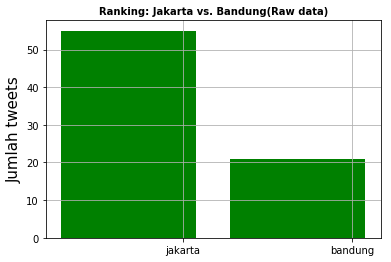

In [ ]:
keyword = ['jakarta', 'bandung']
tweets_by_keyword = [tweets['jakarta'].value_counts()[True], tweets['bandung'].value_counts()[True]]

x_pos = list(range(len(keyword)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_keyword, width, alpha=1, color='g')

# Setting axis labels and ticks
ax.set_ylabel('Jumlah tweets', fontsize=15)
ax.set_title('Ranking: Jakarta vs. Bandung(Raw data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(keyword)
plt.grid()

In [ ]:
def removePunctuation(strs):
    remove = string.punctuation
    remove = remove.replace("-", "") # don't remove hyphens
    remove = remove.replace("@", "") # don't remove hyphens
    remove = remove.replace("#", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern

    h = re.sub(pattern, " ", strs) 
    return h

def replace(strs):
    strs = strs.replace('\n','')
    strs = strs.replace('\t','')
    strs = strs.replace('rt','')
    return strs

def save_akun(tokens):
    regexp = re.compile(r'@[a-z]') 
    hasil = list(filter(regexp.match, tokens))
    return hasil

def save_hastags(tokens):
    regexp = re.compile(r'#[a-z0-9]') 
    hasil = list(filter(regexp.match, tokens))
    return hasil

def save_emoji(tokens):
    regexp = re.compile(r'[😂👏🙄👇🤣😅🙈😀☝🙏👆😐👍🤔😊😉😌😊😉✌🤤😭😃🦄💪😔❤😑👉😆😁🙃💐⚡😎👌💯💃🎶👀☀💞😤👊✊😔🛀🙋👼👥😍✊😃💗👎🤦😁😞😡]') 
    hasil = list(filter(regexp.match, tokens))
    return hasil

def tokenize(strs):
    tokenizer = TweetTokenizer()
    nltk_tokens = tokenizer.tokenize(strs)
    return nltk_tokens

def removeAkunHastagsEmoji(tokens):
    regexp = re.compile(r'@[a-z]') #Hapus @
    filtered = filter(lambda i: not regexp.search(i), tokens)
    filtered = [i for i in tokens if not regexp.search(i)]
    regexp = re.compile(r'#[a-z0-9]') #Hapus #
    filtered = filter(lambda i: not regexp.search(i), filtered)
    filtered = [i for i in filtered if not regexp.search(i)]
    regexp = re.compile(r'[😂👏🙄👇🤣😅🙄🙈😀☝🙏👆😐👍🤔😊😉😌😊😉✌🤤😭😃🦄💪😔❤😑👉😆😁🙃💐⚡😎👌💯💃🎶👀☀💞😤👊✊😔🛀🙋👼👥😍✊😃💗👎🤦😁😞😡]') #Hapus Emoji
    filtered = filter(lambda i: not regexp.search(i), filtered)
    filtered = [i for i in filtered if not regexp.search(i)]
    return filtered


In [ ]:
#PREPROCESSING
#tweet_data = tweets[~tweets.text.str.contains("RT @", "RT@")] 
tweet_data = tweets
tweet_data['text'] = [i.lower() for i in tweet_data.text] #lowertext
tweet_data['text'] = [re.sub(r'http.*', '', i) for i in tweet_data.text] #remove link
tweet_data['text'] = [removePunctuation(i) for i in tweet_data.text] #remove punctuation
tweet_data['text'] = [replace(j) for j in tweet_data.text] #replace \n \t rt
tweet_data['token'] = [tokenize(i) for i in tweet_data.text] #tokenize string
tweet_data['akun'] = [save_akun(i) for i in tweet_data.token] #save account mention
tweet_data['emoji'] = [save_emoji(i) for i in tweet_data.token] #save emoji in text
tweet_data['hastags'] = [save_hastags(i) for i in tweet_data.token] #save hastags in text
tweet_data['token'] = [removeAkunHastagsEmoji(i) for i in tweet_data.token] #remove akun, hastags, emoji


In [ ]:
tweet_data

,text,waktu,jakarta,bandung,token,akun,emoji,hastags
0,@theusmanalu selamat malam informasi perjalanan krl bekasi-jakaa kota via manggarai tersedia pkl 21 36 wib untu…,2021-01-13 12:13:32,True,False,"[selamat, malam, informasi, perjalanan, krl, bekasi-jakaa, kota, via, manggarai, tersedia, pkl, 21, 36, wib, untu, …]",[@theusmanalu],[],[]
1,mau pindah ke jakaa lgi tp harus nyari kontrakan apa itu ga gampang apalagi press budget wkwkwkwkwk,2021-01-13 12:13:33,True,False,"[mau, pindah, ke, jakaa, lgi, tp, harus, nyari, kontrakan, apa, itu, ga, gampang, apalagi, press, budget, wkwkwkwkwk]",[],[],[]
2,@dkijakaa kamu punya hp laptop tablet lebih yuk bantu adik-adik dan guru di jakaa agar bisa belajar dari rumah kita bisa ber…,2021-01-13 12:13:34,True,False,"[kamu, punya, hp, laptop, tablet, lebih, yuk, bantu, adik-adik, dan, guru, di, jakaa, agar, bisa, belajar, dari, rumah, kita, bisa, ber, …]",[@dkijakaa],[],[]
3,tempe tahu sama cabe lagi mahal gak sih soalnya tempe di kang sayur langganan biasanya cuma 5k cabe seperempat b…,2021-01-13 12:13:35,False,False,"[tempe, tahu, sama, cabe, lagi, mahal, gak, sih, soalnya, tempe, di, kang, sayur, langganan, biasanya, cuma, 5k, cabe, seperempat, b, …]",[],[],[]
4,tapi tadi malem beda tadi mlm aku mimpi aku lagi tiduran di mobil otw bandung pas nengok jendela tuh aku sesek n…,2021-01-13 12:13:35,False,True,"[tapi, tadi, malem, beda, tadi, mlm, aku, mimpi, aku, lagi, tiduran, di, mobil, otw, bandung, pas, nengok, jendela, tuh, aku, sesek, n, …]",[],[],[]
5,@pingpingfaith a netizen friend sent me this newsclip headline of the leading newspaper in jakaa indonesia fated october 14 2020 t…,2021-01-13 12:13:35,True,False,"[a, netizen, friend, sent, me, this, newsclip, headline, of, the, leading, newspaper, in, jakaa, indonesia, fated, october, 14, 2020, t, …]",[@pingpingfaith],[],[]
6,@alghifaqsa 13 01 pagi tadi sidang pembuktian gugatan warga negara cls terkait pencemaran udara jakaa koalisi menghadirkan ahli…,2021-01-13 12:13:37,True,False,"[13, 01, pagi, tadi, sidang, pembuktian, gugatan, warga, negara, cls, terkait, pencemaran, udara, jakaa, koalisi, menghadirkan, ahli, …]",[@alghifaqsa],[],[]
7,3 • alhamdulillah @kemensosri bekerja sama dg dukcapil menggandeng bank mandiri utk pembukaan rekening atensi bagi…,2021-01-13 12:13:37,False,False,"[3, •, alhamdulillah, bekerja, sama, dg, dukcapil, menggandeng, bank, mandiri, utk, pembukaan, rekening, atensi, bagi, …]",[@kemensosri],[],[]
8,@88rising “how we used to” 🦋 @poetristephanietomorrow midnight et noon jakaa,2021-01-13 12:13:37,True,False,"[@8, 8rising, “, how, we, used, to, ”, 🦋, midnight, et, noon, jakaa]",[@poetristephanietomorrow],[],[]
9,༺═──•⊱ 𝑭𝒐𝒍𝒍𝒐𝒘 𝒀𝒖𝒌 ⊰•──═༻☞︎︎︎ @isyanabo8☞︎︎︎ @angel isyanaa🔸open bo amp vcs ༺─•⊱ 𝑹𝒆𝒄𝒐𝒎𝒆𝒏𝒅𝒆𝒅 amp 𝑻𝒓𝒖𝒔𝒕𝒆𝒅 ⊰•─༻base…,2021-01-13 12:13:38,False,False,"[༺, ═, ─, ─, •, ⊱, 𝑭𝒐𝒍𝒍𝒐𝒘, 𝒀𝒖𝒌, ⊰, •, ─, ─, ═, ༻, ☞, ︎, ︎, ︎, ☞, ︎, ︎, ︎, isyanaa, 🔸, open, bo, amp, vcs, ༺, ─, •, ⊱, 𝑹𝒆𝒄𝒐𝒎𝒆𝒏𝒅𝒆𝒅, amp, 𝑻𝒓𝒖𝒔𝒕𝒆𝒅, ⊰, •, ─, ༻, base, …]","[@isyanabo8, @angel]",[],[]


In [ ]:
#PREPROCESSING
tweet_data_2 = tweet_data
mask = (tweet_data_2['token'].str.len() >=5)
tweet_data_2 = tweet_data_2.loc[mask] #Remove tweet length < 5
mask = (tweet_data_2['jakarta']==True) | (tweet_data_2['bandung']==True)
tweet_data_2 = tweet_data_2.loc[mask] #Remove irrelevant Tweet

In [ ]:
len(tweet_data_2.token)

72

In [ ]:
tweet_data_2

,text,waktu,jakarta,bandung,token,akun,emoji,hastags
0,@theusmanalu selamat malam informasi perjalanan krl bekasi-jakaa kota via manggarai tersedia pkl 21 36 wib untu…,2021-01-13 12:13:32,True,False,"[selamat, malam, informasi, perjalanan, krl, bekasi-jakaa, kota, via, manggarai, tersedia, pkl, 21, 36, wib, untu, …]",[@theusmanalu],[],[]
1,mau pindah ke jakaa lgi tp harus nyari kontrakan apa itu ga gampang apalagi press budget wkwkwkwkwk,2021-01-13 12:13:33,True,False,"[mau, pindah, ke, jakaa, lgi, tp, harus, nyari, kontrakan, apa, itu, ga, gampang, apalagi, press, budget, wkwkwkwkwk]",[],[],[]
2,@dkijakaa kamu punya hp laptop tablet lebih yuk bantu adik-adik dan guru di jakaa agar bisa belajar dari rumah kita bisa ber…,2021-01-13 12:13:34,True,False,"[kamu, punya, hp, laptop, tablet, lebih, yuk, bantu, adik-adik, dan, guru, di, jakaa, agar, bisa, belajar, dari, rumah, kita, bisa, ber, …]",[@dkijakaa],[],[]
4,tapi tadi malem beda tadi mlm aku mimpi aku lagi tiduran di mobil otw bandung pas nengok jendela tuh aku sesek n…,2021-01-13 12:13:35,False,True,"[tapi, tadi, malem, beda, tadi, mlm, aku, mimpi, aku, lagi, tiduran, di, mobil, otw, bandung, pas, nengok, jendela, tuh, aku, sesek, n, …]",[],[],[]
5,@pingpingfaith a netizen friend sent me this newsclip headline of the leading newspaper in jakaa indonesia fated october 14 2020 t…,2021-01-13 12:13:35,True,False,"[a, netizen, friend, sent, me, this, newsclip, headline, of, the, leading, newspaper, in, jakaa, indonesia, fated, october, 14, 2020, t, …]",[@pingpingfaith],[],[]
6,@alghifaqsa 13 01 pagi tadi sidang pembuktian gugatan warga negara cls terkait pencemaran udara jakaa koalisi menghadirkan ahli…,2021-01-13 12:13:37,True,False,"[13, 01, pagi, tadi, sidang, pembuktian, gugatan, warga, negara, cls, terkait, pencemaran, udara, jakaa, koalisi, menghadirkan, ahli, …]",[@alghifaqsa],[],[]
8,@88rising “how we used to” 🦋 @poetristephanietomorrow midnight et noon jakaa,2021-01-13 12:13:37,True,False,"[@8, 8rising, “, how, we, used, to, ”, 🦋, midnight, et, noon, jakaa]",[@poetristephanietomorrow],[],[]
11,covid19 dki jakaa-13 januari 2021kasus 214728 3476 sbh 191557 2952 mnggl 3595 45 kasus 1juta 20698…,2021-01-13 12:13:40,True,False,"[covid, 19, dki, jakaa, -, 13, januari, 2021kasus, 214728 3476, sbh, 191557 2952, mnggl, 3595, 45, kasus, 1juta, 20698, …]",[],[],[]
12,tweet ini apabila km pejuang ppdb dki jakaa,2021-01-13 12:13:42,True,False,"[tweet, ini, apabila, km, pejuang, ppdb, dki, jakaa]",[],[],[]
13,@rizmaya hening rp 560 miliar 🤭di lingkaran dki jakaa banyak dugaan korupsi yang kesannya didiamkan oleh kpk baik kpk pusat…,2021-01-13 12:13:43,True,False,"[hening, rp, 560, miliar, 🤭, di, lingkaran, dki, jakaa, banyak, dugaan, korupsi, yang, kesannya, didiamkan, oleh, kpk, baik, kpk, pusat, …]",[@rizmaya],[],[]


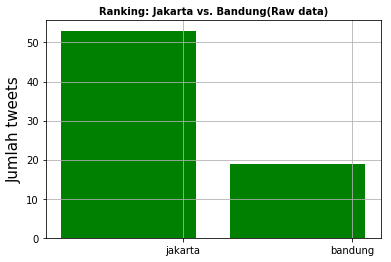

In [ ]:
keyword = ['jakarta', 'bandung']
tweets_by_keyword = [tweet_data_2['jakarta'].value_counts()[True], tweet_data_2['bandung'].value_counts()[True]]

x_pos = list(range(len(keyword)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_keyword, width, alpha=1, color='g')

# Setting axis labels and ticks
ax.set_ylabel('Jumlah tweets', fontsize=15)
ax.set_title('Ranking: Jakarta vs. Bandung(Raw data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(keyword)
plt.grid()

In [ ]:
#STEMMING
tweet_data_3 = tweet_data_2
factory = StemmerFactory()
stemmer = factory.create_stemmer()
tweet_data_3['bersih'] = [' '.join(str(y) for y in x) for x in tweet_data_3.token] #JOIN TEXT
tweet_data_3['bersih'] = [stemmer.stem(x) for x in tweet_data_3.bersih] #STEMMING

In [ ]:
#Tokenize
tweet_data_3['bersih'] = [tokenize(i) for i in tweet_data_3.bersih] #tokenize string

In [ ]:
tweet_data_3

,text,waktu,jakarta,bandung,token,akun,emoji,hastags,bersih
0,@theusmanalu selamat malam informasi perjalanan krl bekasi-jakaa kota via manggarai tersedia pkl 21 36 wib untu…,2021-01-13 12:13:32,True,False,"[selamat, malam, informasi, perjalanan, krl, bekasi-jakaa, kota, via, manggarai, tersedia, pkl, 21, 36, wib, untu, …]",[@theusmanalu],[],[],"[selamat, malam, informasi, jalan, krl, bekasi-jakaa, kota, via, manggarai, sedia, pkl, 21, 36, wib, untu]"
1,mau pindah ke jakaa lgi tp harus nyari kontrakan apa itu ga gampang apalagi press budget wkwkwkwkwk,2021-01-13 12:13:33,True,False,"[mau, pindah, ke, jakaa, lgi, tp, harus, nyari, kontrakan, apa, itu, ga, gampang, apalagi, press, budget, wkwkwkwkwk]",[],[],[],"[mau, pindah, ke, jakaa, lgi, tp, harus, nyari, kontra, apa, itu, ga, gampang, apalagi, press, budget, wkwkwkwkwk]"
2,@dkijakaa kamu punya hp laptop tablet lebih yuk bantu adik-adik dan guru di jakaa agar bisa belajar dari rumah kita bisa ber…,2021-01-13 12:13:34,True,False,"[kamu, punya, hp, laptop, tablet, lebih, yuk, bantu, adik-adik, dan, guru, di, jakaa, agar, bisa, belajar, dari, rumah, kita, bisa, ber, …]",[@dkijakaa],[],[],"[kamu, punya, hp, laptop, tablet, lebih, yuk, bantu, adik, dan, guru, di, jakaa, agar, bisa, ajar, dari, rumah, kita, bisa, ber]"
4,tapi tadi malem beda tadi mlm aku mimpi aku lagi tiduran di mobil otw bandung pas nengok jendela tuh aku sesek n…,2021-01-13 12:13:35,False,True,"[tapi, tadi, malem, beda, tadi, mlm, aku, mimpi, aku, lagi, tiduran, di, mobil, otw, bandung, pas, nengok, jendela, tuh, aku, sesek, n, …]",[],[],[],"[tapi, tadi, malem, beda, tadi, mlm, aku, mimpi, aku, lagi, tidur, di, mobil, otw, bandung, pas, nengok, jendela, tuh, aku, sek, n]"
5,@pingpingfaith a netizen friend sent me this newsclip headline of the leading newspaper in jakaa indonesia fated october 14 2020 t…,2021-01-13 12:13:35,True,False,"[a, netizen, friend, sent, me, this, newsclip, headline, of, the, leading, newspaper, in, jakaa, indonesia, fated, october, 14, 2020, t, …]",[@pingpingfaith],[],[],"[a, netizen, friend, sent, me, this, newsclip, headline, of, the, leading, newspaper, in, jakaa, indonesia, fated, october, 14, 2020, t]"
6,@alghifaqsa 13 01 pagi tadi sidang pembuktian gugatan warga negara cls terkait pencemaran udara jakaa koalisi menghadirkan ahli…,2021-01-13 12:13:37,True,False,"[13, 01, pagi, tadi, sidang, pembuktian, gugatan, warga, negara, cls, terkait, pencemaran, udara, jakaa, koalisi, menghadirkan, ahli, …]",[@alghifaqsa],[],[],"[13, 01, pagi, tadi, sidang, bukti, gugat, warga, negara, cls, kait, cemar, udara, jakaa, koalisi, hadir, ahli]"
8,@88rising “how we used to” 🦋 @poetristephanietomorrow midnight et noon jakaa,2021-01-13 12:13:37,True,False,"[@8, 8rising, “, how, we, used, to, ”, 🦋, midnight, et, noon, jakaa]",[@poetristephanietomorrow],[],[],"[8, 8rising, how, we, used, to, midnight, et, noon, jakaa]"
11,covid19 dki jakaa-13 januari 2021kasus 214728 3476 sbh 191557 2952 mnggl 3595 45 kasus 1juta 20698…,2021-01-13 12:13:40,True,False,"[covid, 19, dki, jakaa, -, 13, januari, 2021kasus, 214728 3476, sbh, 191557 2952, mnggl, 3595, 45, kasus, 1juta, 20698, …]",[],[],[],"[covid, 19, dki, jakaa, -, 13, januari, 2021kasus, 214728 3476, sbh, 191557 2952, mnggl, 3595, 45, kasus, 1juta, 20698]"
12,tweet ini apabila km pejuang ppdb dki jakaa,2021-01-13 12:13:42,True,False,"[tweet, ini, apabila, km, pejuang, ppdb, dki, jakaa]",[],[],[],"[tweet, ini, apabila, km, juang, ppdb, dki, jakaa]"
13,@rizmaya hening rp 560 miliar 🤭di lingkaran dki jakaa banyak dugaan korupsi yang kesannya didiamkan oleh kpk baik kpk pusat…,2021-01-13 12:13:43,True,False,"[hening, rp, 560, miliar, 🤭, di, lingkaran, dki, jakaa, banyak, dugaan, korupsi, yang, kesannya, didiamkan, oleh, kpk, baik, kpk, pusat, …]",[@rizmaya],[],[],"[hening, rp, 560, miliar, di, lingkar, dki, jakaa, banyak, duga, korupsi, yang, kesan, diam, oleh, kpk, baik, kpk, pusat]"


In [ ]:
#Frequent word & STOPWORD
stopwords = set(line.strip() for line in open('stopword.txt'))
wordcount = {}
word_counter = collections.Counter(wordcount)
for x in tweet_data_3.bersih:
    for y in x:
        if y not in stopwords:
            if y not in wordcount:
                wordcount[y] = 1
            else:
                wordcount[y] += 1

In [ ]:
wordcount

{'selamat': 1,
 'malam': 1,
 'informasi': 1,
 'jalan': 2,
 'krl': 1,
 'bekasi-jakaa': 1,
 'kota': 5,
 'via': 3,
 'manggarai': 1,
 'sedia': 1,
 'pkl': 1,
 '21': 1,
 '36': 2,
 'wib': 2,
 'untu': 1,
 'pindah': 1,
 'jakaa': 49,
 'lgi': 1,
 'tp': 1,
 'nyari': 1,
 'kontra': 1,
 'ga': 1,
 'gampang': 1,
 'press': 1,
 'budget': 1,
 'wkwkwkwkwk': 1,
 'hp': 1,
 'laptop': 1,
 'tablet': 1,
 'yuk': 2,
 'bantu': 1,
 'adik': 1,
 'guru': 1,
 'ajar': 1,
 'rumah': 2,
 'ber': 1,
 'malem': 1,
 'beda': 1,
 'mlm': 1,
 'mimpi': 1,
 'tidur': 1,
 'mobil': 1,
 'otw': 1,
 'bandung': 17,
 'pas': 2,
 'nengok': 1,
 'jendela': 1,
 'tuh': 3,
 'sek': 1,
 'n': 1,
 'a': 2,
 'netizen': 1,
 'friend': 1,
 'sent': 1,
 'me': 3,
 'this': 1,
 'newsclip': 1,
 'headline': 1,
 'of': 1,
 'the': 2,
 'leading': 1,
 'newspaper': 1,
 'in': 8,
 'indonesia': 1,
 'fated': 1,
 'october': 1,
 '14': 1,
 '2020': 1,
 't': 1,
 '13': 5,
 '01': 2,
 'pagi': 2,
 'sidang': 2,
 'bukti': 2,
 'gugat': 2,
 'warga': 2,
 'negara': 2,
 'cls': 2,
 'kait': 2

In [ ]:
mydict = {k:v for k,v in wordcount.items()}

In [ ]:
new_pd = pd.DataFrame.from_dict(mydict, orient='index',columns=['nama'])

In [ ]:
new_pd.to_csv("wordcount.csv")

In [ ]:
with open('wordcount.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(str(mydict.keys()))

In [ ]:
#MAPPING KE KBBI
word_counter = collections.Counter(wordcount)
words = []
for word, count in word_counter.most_common(10000):
    try:
        KBBI(word)
        words.append({word:count})
    except:
        print("tidak ada "+word)
    #print(word, ": ", count)

tidak ada jakaa
tidak ada in
tidak ada dki
tidak ada out
tidak ada 13
tidak ada 560
tidak ada 5
tidak ada outsation
tidak ada sriwijaya
tidak ada ngan
tidak ada scandal
tidak ada full
tidak ada 08571810249
tidak ada 9
tidak ada amp
tidak ada -
tidak ada k1n9f4t1ra7a
tidak ada 1966
tidak ada tritu
tidak ada gracia
tidak ada 36
tidak ada the
tidak ada 01
tidak ada cls
tidak ada 8
tidak ada covid
tidak ada 19
tidak ada tweet
tidak ada ppdb
tidak ada shopeepaypacking
tidak ada peama
tidak ada 1


In [ ]:
try:
    KBBI('cintaa')
    KBBI('cinta')
except:
    print("tidak ada")